In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from datetime import date,timedelta
import random

START_YEAR = 2000
END_YEAR = 2550

start_year = START_YEAR
end_year   = END_YEAR
    
if start_year < 1773:
    print 'you went too far in the past!' #send_to_geoffrey
    print 'your dataset will start in 1772.' #send_to_geoffrey
    start_year = 1773
    
if end_year > date.today().year:
    print 'the last full historic year is '+str(date.today().year)
    print 'but I will provide you a forecast until the last year selected'

if end_year > 2250:
    print 'aliens will likely be among us by '+str(end_year)
    print "let's just run the forecast until 2250"
    end_year   = 2250 
    
if end_year<start_year:
    print 'you have selected an end year lower than the start year,' #send_to_geoffrey
    end_year   = start_year + 1
    print 'your end year will be '+str(end_year) #send_to_geoffrey

the last full historic year is 2017
but I will provide you a forecast until the last year selected
aliens will likely be among us by 2550
let's just run the forecast until 2250


In [2]:
print 'Let me read the OLDEST daily weather data thanks to -> http://www.metoffice.gov.uk/hadobs/hadcet/index.html' #send_to_geoffrey
print 'I need to transform all the data to make it workable'

df = pd.read_csv('https://www.dropbox.com/s/jfhpzfnsrkrve6q/cetdl1772on.dat.csv?dl=1')
for col in df.columns:
    if col=='0':
        df.rename(columns={col:'year'},inplace=True)
    elif col=='1':
        df.rename(columns={col:'day'},inplace=True)
    else:
        df.rename(columns={col:int(col)-1},inplace=True)
df = df.replace(-999,np.nan)
months = list(df.columns[2:].values)
        
data = pd.melt(df ,id_vars=['year','day'], value_vars=months)
data.rename(columns={'variable':'month','value':'mean_temp'},inplace=True)

df=pd.read_csv('https://www.dropbox.com/s/nbghb1v18y3if7i/cet_mean_2017.csv?dl=1')
        
for col in df.columns:
    if col=='0':
        df.rename(columns={col:'day'},inplace=True)
                
df = df.drop(df.index[[0, 1, 2]])
        
months = list(df.columns[1:].values)
data_2017 = pd.melt(df ,id_vars=['day'], value_vars=months)
data_2017['year'] = 2017
data_2017.rename(columns={'variable':'month','value':'mean_temp'},inplace=True)
                     
data_2017 = data_2017.replace(-32768,np.nan)

all_data = pd.concat([data_2017,data])
all_data = all_data.dropna()

all_data['day'] = all_data['day'].apply(int)
all_data['month'] = all_data['month'].apply(int)

all_data['date'] = pd.to_datetime(all_data.year*10000+all_data.month*100+all_data.day,format='%Y%m%d')
all_data['mean_temp']= all_data['mean_temp']/10

Let me read the OLDEST daily weather data thanks to -> http://www.metoffice.gov.uk/hadobs/hadcet/index.html
I need to transform all the data to make it workable


In [3]:
###average temperatures###

df_mean_temp = pd.pivot_table(all_data[all_data['year']<1920],columns =['day','month'],values =['mean_temp'],aggfunc='mean')
df_mean_temp = df_mean_temp.reset_index()
df_mean_temp.rename(columns={0:'all_time_mean_temp'},inplace=True)
temp_and_avg = all_data.merge(df_mean_temp[['day','month','all_time_mean_temp']],on=['day','month'],how='left')
temp_and_avg = temp_and_avg.sort('date')
#temp_and_avg['delta'] = temp_and_avg['mean_temp']-temp_and_avg['all_time_mean_temp']


/Users/xorduna/devel/abi/notebot/ntenv/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  import sys


In [4]:
pl = temp_and_avg.groupby(['year'])['mean_temp'].mean()

pl = pl.iloc[(pl.index> 1800)&(pl.index< 2017)]

pl = pl.reset_index()

POLINOMIAL_A = 2
z2=np.polyfit(pl['year'], pl['mean_temp'], POLINOMIAL_A ,full=True)
z2_coef=z2[0]

z2_resid=z2[1]
r2_z2 = 1 - z2_resid / (pl['mean_temp'].size * pl['mean_temp'].var())
p2=  np.poly1d(z2_coef)
print p2

polifit_result= p2 , '--> explains: %' ,round(r2_z2[0],POLINOMIAL_A), 'of the variability'
print polifit_result

range_years = end_year-1772
years  = np.arange(range_years)+1772
#print years     

def forecasting_formula(year):
    prediciton_year_temp = np.array(p2(year))
    return prediciton_year_temp


           2
3.958e-05 x - 0.1464 x + 144.4
(poly1d([  3.95841111e-05,  -1.46363216e-01,   1.44409315e+02]), '--> explains: %', 0.26, 'of the variability')


In [5]:
f_df_mean_temp = pd.pivot_table(all_data[all_data['year']>1920],columns =['day','month'],values =['mean_temp'],aggfunc='mean')
f_df_mean_temp = f_df_mean_temp.reset_index()
f_df_mean_temp.rename(columns ={0:'last_century_mean_temp'},inplace=True)
mena_temp_2009 = pl['mean_temp'][(pl['year']==2009)].values[0]

In [6]:
concat_forecast = pd.DataFrame()

range_years = end_year-1772
years  = np.arange(range_years)+1772
#print years 
for year in years[245:]:
    
    #year_forecast  = forecast['forecast'][(forecast['year']==year)].values[0]
    year_temps = pd.DataFrame(pd.date_range(start=date(year,01,01),end=date(year,12,31),freq='D'),columns=['date'])
    year_temps['month'] = year_temps['date'].dt.month
    year_temps['day'] = year_temps['date'].dt.day
    year_temps = year_temps.merge(f_df_mean_temp[['day','month','last_century_mean_temp']],on =['day','month'],how='left')
    year_temps['year_mean'] = year_temps['last_century_mean_temp'].mean()

    concat_forecast = pd.concat([concat_forecast,year_temps])
    
    
concat_forecast['year'] = concat_forecast['date'].dt.year  
concat_forecast['model_year_mean'] = concat_forecast['year'].apply(forecasting_formula)
concat_forecast['f_year_mean'] = concat_forecast['last_century_mean_temp'] * concat_forecast['model_year_mean']/ concat_forecast['year_mean'] 

concat_forecast = concat_forecast[['date','year','month','day','f_year_mean']]

In [1]:
final_dataset = pd.concat([temp_and_avg,concat_forecast])
final_dataset = final_dataset.drop_duplicates('date',keep ='first')
final_dataset['model_year_mean'] = final_dataset['year'].apply(forecasting_formula)

final_dataset.to_csv('output.csv')
#SENDFILE output.csv
final_dataset.to_excel('output.xlsx')
#SENDFILE output.xlsx
print 'output.csv'
print 'output.xlsx'

NameError: name 'pd' is not defined

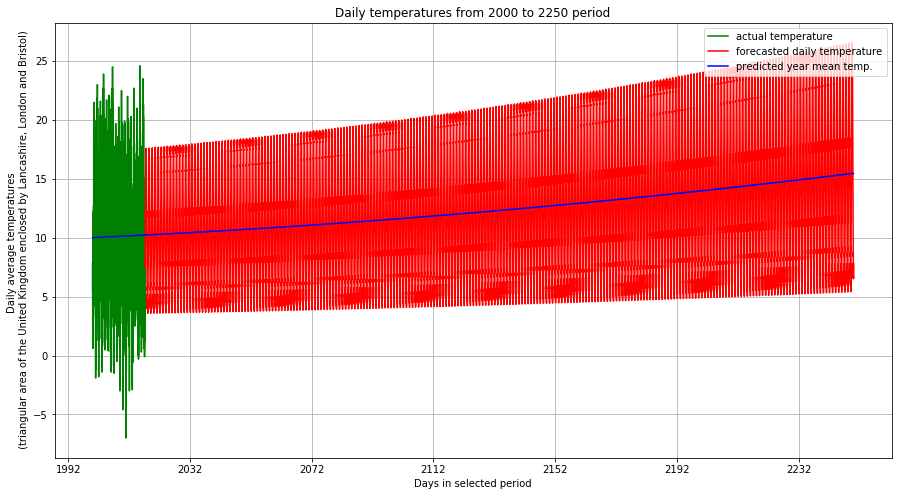

In [8]:
final_dataset_plot = final_dataset[(final_dataset['year']>=start_year)&
                                                 (final_dataset['year']<=end_year)]

final_dataset_plot = final_dataset_plot.set_index('date')

xp = np.linspace(.5, 1.5, 100)

#y_axis = temp_and_avg_plot_start_year['mean_temp']

fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.set_title('Daily temperatures from '+ str(start_year) +' to '+ str(end_year)+' period')
ax1.set_ylabel('Daily average temperatures \n (triangular area of the United Kingdom enclosed by Lancashire, London and Bristol)')
ax1.set_xlabel('Days in selected period')


ax1.plot(final_dataset_plot['mean_temp'],'g',label='actual temperature')
ax1.plot(final_dataset_plot['f_year_mean'],'r',label='forecasted daily temperature')
ax1.plot(final_dataset_plot['model_year_mean'],'b',label='predicted year mean temp.')

handles, labels = ax1.get_legend_handles_labels()

plt.legend(handles, labels,loc=1)
plt.grid()     #send_to_geoffrey       
        